In [1]:
#pip install numpy opencv-python pillow tensorflow keras imutils scikit-learn matplotlib

# Impoted Libraries

In [2]:
import psutil
import humanize
import os
from IPython.display import display_html
import numpy as np
import pandas as pd 
import os
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline
import tensorflow as tf

In [3]:
dataDirectory="C:\\Users\\91810\\OneDrive\\Desktop\\Research\\Live project semester 4\\data"
print(os.listdir(dataDirectory))

['normal', 'osteopenia', 'osteoporosis']


# Sample Images

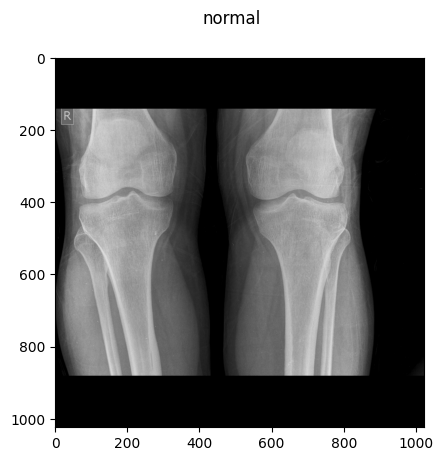

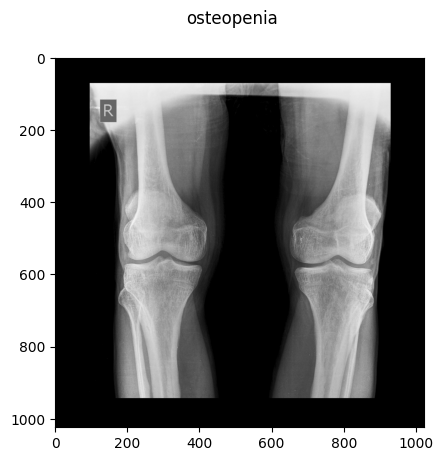

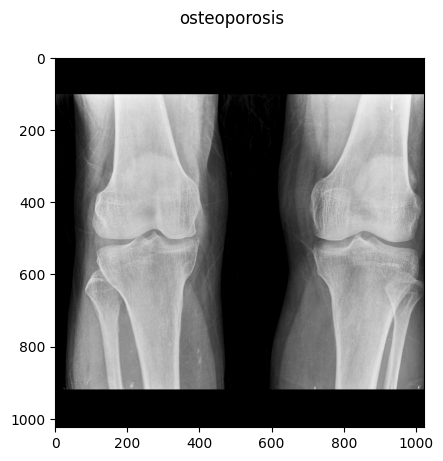

In [4]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

normal_images = []
for img_path in glob.glob(dataDirectory + '/normal/*'):
    normal_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('normal')
plt.imshow(normal_images[0], cmap='gray') 

osteopenia_images = []
for img_path in glob.glob(dataDirectory + '/osteopenia/*'):
    osteopenia_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('osteopenia')
plt.imshow(osteopenia_images[0], cmap='gray') 

osteoporosis_images = []
for img_path in glob.glob(dataDirectory + '/osteoporosis/*'):
    osteoporosis_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('osteoporosis')
plt.imshow(osteoporosis_images[0], cmap='gray') 

In [5]:
print(len(normal_images))
print(len(osteopenia_images))
print(len( osteoporosis_images))

36
154
49


In [6]:
IMG_W = 150
IMG_H = 150
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 3
EPOCHS = 3
batchSize = 6
BATCH_SIZE = 6

# Data Generator

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    dataDirectory,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
   dataDirectory, 
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle= False,
    subset='validation')

Found 169 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


# Load data from directory

In [8]:
selectedClasses = ['normal', 'osteopenia','osteoporosis'] 

In [9]:
print ("In train_generator ")
for cls in range(len (train_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(train_generator.classes).count(cls))
print ("") 

print ("In validation_generator ")
for cls in range(len (validation_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(validation_generator.classes).count(cls))
print ("") 

In train_generator 
normal :	 26
osteopenia :	 108
osteoporosis :	 35

In validation_generator 
normal :	 10
osteopenia :	 46
osteoporosis :	 14



# Auxilary Functions for ploting images

In [10]:
#plots images with labels within jupyter notebook
def plots(ims, figsize = (22,22), rows=4, interp=False, titles=None, maxNum = 9):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
           
    f = plt.figure(figsize=figsize)
    #cols = len(ims) //rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    cols = maxNum // rows if maxNum % 2 == 0 else maxNum//rows + 1
    #for i in range(len(ims)):
    for i in range(maxNum):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=20)
        plt.imshow(ims[i], interpolation = None if interp else 'none')   

# Create model by Transfer Learning from InceptionV3

VGG 16

In [11]:
baseVGG16=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
baseVGG16.trainable = False

x = baseVGG16.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(selectedClasses), activation='softmax')(x)

model_VGG16 = Model(inputs=baseVGG16.input, outputs=predictions)


model_VGG16.summary()    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

VGG19

In [12]:
baseVGG19 = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
baseVGG19.trainable = False

x = baseVGG19.output
x = keras.layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
# and a sofymax/logistic layer -- we have 3 classes
predictions = Dense(len(selectedClasses), activation='softmax')(x)

# this is the model we will train
model_VGG19 = Model(inputs=baseVGG19.input, outputs=predictions)


model_VGG19.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

DenseNet169

In [13]:
baseDenseNet169 = tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
baseDenseNet169.trainable = False

x = baseDenseNet169.output
x = keras.layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
# and a sofymax/logistic layer -- we have 3 classes
predictions = Dense(len(selectedClasses), activation='softmax')(x)

# this is the model we will train
model_DenseNet169 = Model(inputs=baseDenseNet169.input, outputs=predictions)


model_DenseNet169.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                         

                                                                                                  
 conv2_block3_concat (Concatena  (None, None, None,   0          ['conv2_block2_concat[0][0]',    
 te)                            160)                              'conv2_block3_2_conv[0][0]']    
                                                                                                  
 conv2_block4_0_bn (BatchNormal  (None, None, None,   640        ['conv2_block3_concat[0][0]']    
 ization)                       160)                                                              
                                                                                                  
 conv2_block4_0_relu (Activatio  (None, None, None,   0          ['conv2_block4_0_bn[0][0]']      
 n)                             160)                                                              
                                                                                                  
 conv2_blo

 n)                             128)                                                              
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, None, None,   16384       ['conv3_block1_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, None, None,   0          ['conv3_block1_1_bn[0][0]']      
 n)                             128)                                                              
          

 conv3_block5_0_relu (Activatio  (None, None, None,   0          ['conv3_block5_0_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv3_block5_1_conv (Conv2D)   (None, None, None,   32768       ['conv3_block5_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block5_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, None, None,   0          ['conv3_block5_1_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block9_0_relu (Activatio  (None, None, None,   0          ['conv3_block9_0_bn[0][0]']      
 n)                             384)                                                              
                                                                                                  
 conv3_block9_1_conv (Conv2D)   (None, None, None,   49152       ['conv3_block9_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block9_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block9_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_blo

                                512)                                                              
                                                                                                  
 pool3_relu (Activation)        (None, None, None,   0           ['pool3_bn[0][0]']               
                                512)                                                              
                                                                                                  
 pool3_conv (Conv2D)            (None, None, None,   131072      ['pool3_relu[0][0]']             
                                256)                                                              
                                                                                                  
 pool3_pool (AveragePooling2D)  (None, None, None,   0           ['pool3_conv[0][0]']             
                                256)                                                              
          

 conv4_block4_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block4_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, None, None,   0          ['conv4_block4_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block4_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_block4_concat (Concatena  (None, None, None,   0          ['conv4_block3_concat[0][0]',    
 te)      

                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block8_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, None, None,   0          ['conv4_block8_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block8_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block8_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_blo

                                128)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block12_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block12_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block12_1_relu[0][0]']   
                                32)                                                               
          

 conv4_block16_1_conv (Conv2D)  (None, None, None,   94208       ['conv4_block16_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block16_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block16_1_relu (Activati  (None, None, None,   0          ['conv4_block16_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block16_1_relu[0][0]']   
          

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, None, None,   110592      ['conv4_block20_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block20_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block20_1_relu (Activati  (None, None, None,   0          ['conv4_block20_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_blo

 on)                            992)                                                              
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, None, None,   126976      ['conv4_block24_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block24_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block24_1_relu (Activati  (None, None, None,   0          ['conv4_block24_1_bn[0][0]']     
 on)                            128)                                                              
          

 conv4_block28_0_relu (Activati  (None, None, None,   0          ['conv4_block28_0_bn[0][0]']     
 on)                            1120)                                                             
                                                                                                  
 conv4_block28_1_conv (Conv2D)  (None, None, None,   143360      ['conv4_block28_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block28_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block28_1_relu (Activati  (None, None, None,   0          ['conv4_block28_1_bn[0][0]']     
 on)      

                                                                                                  
 conv4_block32_0_relu (Activati  (None, None, None,   0          ['conv4_block32_0_bn[0][0]']     
 on)                            1248)                                                             
                                                                                                  
 conv4_block32_1_conv (Conv2D)  (None, None, None,   159744      ['conv4_block32_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block32_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block32_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_blo

 ization)                       128)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   36864       ['conv5_block3_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv5_block3_concat (Concatena  (None, None, None,   0          ['conv5_block2_concat[0][0]',    
 te)                            736)                              'conv5_block3_2_conv[0][0]']    
          

 conv5_block7_1_bn (BatchNormal  (None, None, None,   512        ['conv5_block7_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv5_block7_1_relu (Activatio  (None, None, None,   0          ['conv5_block7_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_block7_2_conv (Conv2D)   (None, None, None,   36864       ['conv5_block7_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv5_block7_concat (Concatena  (None, None, None,   0          ['conv5_block6_concat[0][0]',    
 te)      

                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block11_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block11_1_relu (Activati  (None, None, None,   0          ['conv5_block11_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, None, None,   36864       ['conv5_block11_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv5_blo

                                128)                                                              
                                                                                                  
 conv5_block15_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block15_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block15_1_relu (Activati  (None, None, None,   0          ['conv5_block15_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, None, None,   36864       ['conv5_block15_1_relu[0][0]']   
                                32)                                                               
          

 conv5_block19_1_conv (Conv2D)  (None, None, None,   155648      ['conv5_block19_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block19_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block19_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block19_1_relu (Activati  (None, None, None,   0          ['conv5_block19_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv5_block19_2_conv (Conv2D)  (None, None, None,   36864       ['conv5_block19_1_relu[0][0]']   
          

                                                                                                  
 conv5_block23_1_conv (Conv2D)  (None, None, None,   172032      ['conv5_block23_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block23_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block23_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block23_1_relu (Activati  (None, None, None,   0          ['conv5_block23_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv5_blo

 on)                            1472)                                                             
                                                                                                  
 conv5_block27_1_conv (Conv2D)  (None, None, None,   188416      ['conv5_block27_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block27_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block27_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block27_1_relu (Activati  (None, None, None,   0          ['conv5_block27_1_bn[0][0]']     
 on)                            128)                                                              
          

 conv5_block31_0_relu (Activati  (None, None, None,   0          ['conv5_block31_0_bn[0][0]']     
 on)                            1600)                                                             
                                                                                                  
 conv5_block31_1_conv (Conv2D)  (None, None, None,   204800      ['conv5_block31_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block31_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block31_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block31_1_relu (Activati  (None, None, None,   0          ['conv5_block31_1_bn[0][0]']     
 on)      

ConvNeXtTiny

In [14]:
baseConvNeXtTiny = tf.keras.applications.ConvNeXtTiny(
    model_name="convnext_tiny",
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

baseConvNeXtTiny.trainable = False

x = baseConvNeXtTiny.output
x = keras.layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
# and a sofymax/logistic layer -- we have 3 classes
predictions = Dense(len(selectedClasses), activation='softmax')(x)

# this is the model we will train
model_ConvNeXtTiny = Model(inputs=baseConvNeXtTiny.input, outputs=predictions)


model_ConvNeXtTiny.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 convnext_tiny_prestem_normaliz  (None, None, None,   0          ['input_4[0][0]']                
 ation (Normalization)          3)                                                                
                                                                                                  
 convnext_tiny_stem (Sequential  (None, None, None,   4896       ['convnext_tiny_prestem_normaliza
 )                              96)                              tion[0][0]']               

 tf.__operators__.add_2 (TFOpLa  (None, None, None,   0          ['tf.__operators__.add_1[0][0]', 
 mbda)                          96)                               'convnext_tiny_stage_0_block_2_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_tiny_downsampling_blo  (None, None, None,   74112      ['tf.__operators__.add_2[0][0]'] 
 ck_0 (Sequential)              192)                                                              
                                                                                                  
 convnext_tiny_stage_1_block_0_  (None, None, None,   9600       ['convnext_tiny_downsampling_bloc
 depthwise_conv (Conv2D)        192)                             k_0[0][0]']                      
                                                                                                  
 convnext_

 convnext_tiny_downsampling_blo  (None, None, None,   295680     ['tf.__operators__.add_5[0][0]'] 
 ck_1 (Sequential)              384)                                                              
                                                                                                  
 convnext_tiny_stage_2_block_0_  (None, None, None,   19200      ['convnext_tiny_downsampling_bloc
 depthwise_conv (Conv2D)        384)                             k_1[0][0]']                      
                                                                                                  
 convnext_tiny_stage_2_block_0_  (None, None, None,   768        ['convnext_tiny_stage_2_block_0_d
 layernorm (LayerNormalization)  384)                            epthwise_conv[0][0]']            
                                                                                                  
 convnext_tiny_stage_2_block_0_  (None, None, None,   591360     ['convnext_tiny_stage_2_block_0_l
 pointwise

 layernorm (LayerNormalization)  384)                            epthwise_conv[0][0]']            
                                                                                                  
 convnext_tiny_stage_2_block_3_  (None, None, None,   591360     ['convnext_tiny_stage_2_block_3_l
 pointwise_conv_1 (Dense)       1536)                            ayernorm[0][0]']                 
                                                                                                  
 convnext_tiny_stage_2_block_3_  (None, None, None,   0          ['convnext_tiny_stage_2_block_3_p
 gelu (Activation)              1536)                            ointwise_conv_1[0][0]']          
                                                                                                  
 convnext_tiny_stage_2_block_3_  (None, None, None,   590208     ['convnext_tiny_stage_2_block_3_g
 pointwise_conv_2 (Dense)       384)                             elu[0][0]']                      
          

 convnext_tiny_stage_2_block_6_  (None, None, None,   590208     ['convnext_tiny_stage_2_block_6_g
 pointwise_conv_2 (Dense)       384)                             elu[0][0]']                      
                                                                                                  
 convnext_tiny_stage_2_block_6_  (None, None, None,   384        ['convnext_tiny_stage_2_block_6_p
 layer_scale (LayerScale)       384)                             ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_tiny_stage_2_block_6_  (None, None, None,   0          ['convnext_tiny_stage_2_block_6_l
 identity (Activation)          384)                             ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_12 (TFOpL  (None, None, None,   0          ['tf.__operators__.add_11[0][0]',
 ambda)   

                                                                                                  
 convnext_tiny_stage_3_block_0_  (None, None, None,   0          ['convnext_tiny_stage_3_block_0_l
 identity (Activation)          768)                             ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, None, None,   0          ['convnext_tiny_downsampling_bloc
 ambda)                         768)                             k_2[0][0]',                      
                                                                  'convnext_tiny_stage_3_block_0_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_tiny_stage_3_block_1_  (None, None, None,   38400      ['tf.__operators__.add_15[0][0]']
 depthwise

# Model checkpoint

In [15]:
modelName= "InceptionTutorial"
#save the best weights over the same file with the model name

#filepath="checkpoints/"+modelName+"_bestweights.hdf5"
filepath=modelName+"_bestweights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Compile the model

In [16]:
model_VGG16.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_VGG19.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_DenseNet169.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_ConvNeXtTiny.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# **Train the model**

In [17]:
stepsPerEpoch= (train_generator.samples+ (batchSize-1)) // batchSize
print("stepsPerEpoch: ", stepsPerEpoch)

validationSteps=(validation_generator.samples+ (batchSize-1)) // batchSize
print("validationSteps: ", validationSteps)

stepsPerEpoch:  29
validationSteps:  12


VGG 16

In [18]:
train_generator.reset()
validation_generator.reset()

# Fit the model
history_VGG16 = model_VGG16.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs = 25,
    steps_per_epoch = stepsPerEpoch,
    validation_steps= validationSteps,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/25
29/29 [==============================] - ETA: 0s - loss: 1.6702 - accuracy: 0.2959
Epoch 1: val_accuracy improved from -inf to 0.65714, saving model to InceptionTutorial_bestweights.hdf5
29/29 [==============================] - 22s 731ms/step - loss: 1.6702 - accuracy: 0.2959 - val_loss: 0.9574 - val_accuracy: 0.6571
Epoch 2/25
29/29 [==============================] - ETA: 0s - loss: 1.1442 - accuracy: 0.4320
Epoch 2: val_accuracy did not improve from 0.65714
29/29 [==============================] - 26s 905ms/step - loss: 1.1442 - accuracy: 0.4320 - val_loss: 0.9309 - val_accuracy: 0.6571
Epoch 3/25
29/29 [==============================] - ETA: 0s - loss: 0.9843 - accuracy: 0.6391
Epoch 3: val_accuracy did not improve from 0.65714
29/29 [==============================] - 23s 793ms/step - loss: 0.9843 - accuracy: 0.6391 - val_loss: 0.9606 - val_accuracy: 0.6571
Epoch 4/25
29/29 [==============================] - ETA: 0s - loss: 0.9280 - accuracy: 0.6154
Epoch 4: val_accuracy 

VGG 19

In [19]:
train_generator.reset()
validation_generator.reset()

# Fit the model
history_VGG19 = model_VGG19.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs = 25,
    steps_per_epoch = stepsPerEpoch,
    validation_steps= validationSteps,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/25
29/29 [==============================] - ETA: 0s - loss: 0.9740 - accuracy: 0.6036
Epoch 1: val_accuracy did not improve from 0.65714
29/29 [==============================] - 26s 884ms/step - loss: 0.9740 - accuracy: 0.6036 - val_loss: 0.8856 - val_accuracy: 0.6571
Epoch 2/25
29/29 [==============================] - ETA: 0s - loss: 0.9622 - accuracy: 0.6095
Epoch 2: val_accuracy did not improve from 0.65714
29/29 [==============================] - 27s 930ms/step - loss: 0.9622 - accuracy: 0.6095 - val_loss: 0.9245 - val_accuracy: 0.6571
Epoch 3/25
29/29 [==============================] - ETA: 0s - loss: 0.9108 - accuracy: 0.6509
Epoch 3: val_accuracy did not improve from 0.65714
29/29 [==============================] - 26s 901ms/step - loss: 0.9108 - accuracy: 0.6509 - val_loss: 0.9686 - val_accuracy: 0.6571
Epoch 4/25
29/29 [==============================] - ETA: 0s - loss: 0.8775 - accuracy: 0.6272
Epoch 4: val_accuracy did not improve from 0.65714
29/29 [=================

DenseNet169

In [20]:
train_generator.reset()
validation_generator.reset()

# Fit the model
history_DenseNet169 = model_DenseNet169.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs = 25,
    steps_per_epoch = stepsPerEpoch,
    validation_steps= validationSteps,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/25
29/29 [==============================] - ETA: 0s - loss: 1.6533 - accuracy: 0.4556
Epoch 1: val_accuracy did not improve from 0.65714
29/29 [==============================] - 28s 671ms/step - loss: 1.6533 - accuracy: 0.4556 - val_loss: 1.9270 - val_accuracy: 0.1286
Epoch 2/25
29/29 [==============================] - ETA: 0s - loss: 1.1377 - accuracy: 0.5621
Epoch 2: val_accuracy did not improve from 0.65714
29/29 [==============================] - 18s 599ms/step - loss: 1.1377 - accuracy: 0.5621 - val_loss: 2.2631 - val_accuracy: 0.1571
Epoch 3/25
29/29 [==============================] - ETA: 0s - loss: 1.2077 - accuracy: 0.5799
Epoch 3: val_accuracy did not improve from 0.65714
29/29 [==============================] - 17s 609ms/step - loss: 1.2077 - accuracy: 0.5799 - val_loss: 1.9625 - val_accuracy: 0.3000
Epoch 4/25
29/29 [==============================] - ETA: 0s - loss: 0.9282 - accuracy: 0.6391
Epoch 4: val_accuracy did not improve from 0.65714
29/29 [=================

ConvNeXtTiny

In [21]:
train_generator.reset()
validation_generator.reset()

# Fit the model
history_ConvNeXtTiny = model_ConvNeXtTiny.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs = 25,
    steps_per_epoch = stepsPerEpoch,
    validation_steps= validationSteps,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/25
29/29 [==============================] - ETA: 0s - loss: 1.2409 - accuracy: 0.4852
Epoch 1: val_accuracy did not improve from 0.65714
29/29 [==============================] - 87s 3s/step - loss: 1.2409 - accuracy: 0.4852 - val_loss: 1.0741 - val_accuracy: 0.6571
Epoch 2/25
29/29 [==============================] - ETA: 0s - loss: 1.1370 - accuracy: 0.5503
Epoch 2: val_accuracy did not improve from 0.65714
29/29 [==============================] - 78s 3s/step - loss: 1.1370 - accuracy: 0.5503 - val_loss: 1.0253 - val_accuracy: 0.6571
Epoch 3/25
29/29 [==============================] - ETA: 0s - loss: 0.9947 - accuracy: 0.5680
Epoch 3: val_accuracy did not improve from 0.65714
29/29 [==============================] - 79s 3s/step - loss: 0.9947 - accuracy: 0.5680 - val_loss: 1.0802 - val_accuracy: 0.6571
Epoch 4/25
29/29 [==============================] - ETA: 0s - loss: 0.9359 - accuracy: 0.6154
Epoch 4: val_accuracy did not improve from 0.65714
29/29 [==========================

# **Show Training History**

VGG 16

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


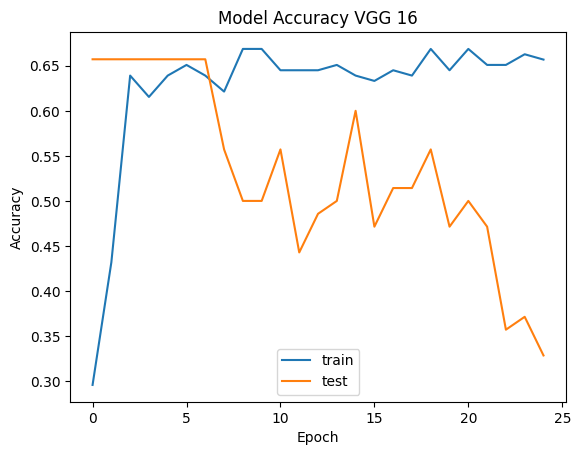

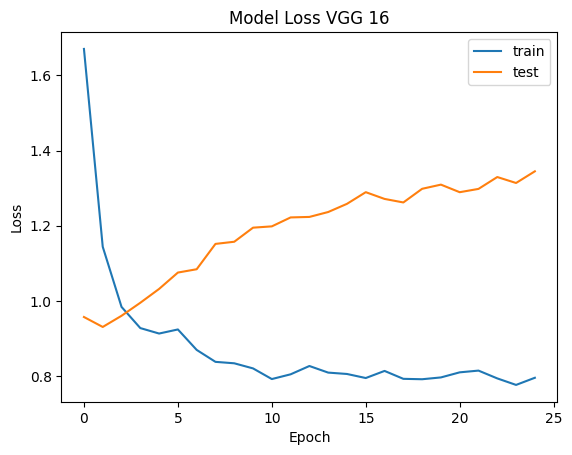

In [22]:
# list all data in history
print(history_VGG16.history.keys())
# summarize history for accuracy
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16.history['val_accuracy'])
plt.title('Model Accuracy VGG 16')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.title('Model Loss VGG 16')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

VGG 19

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


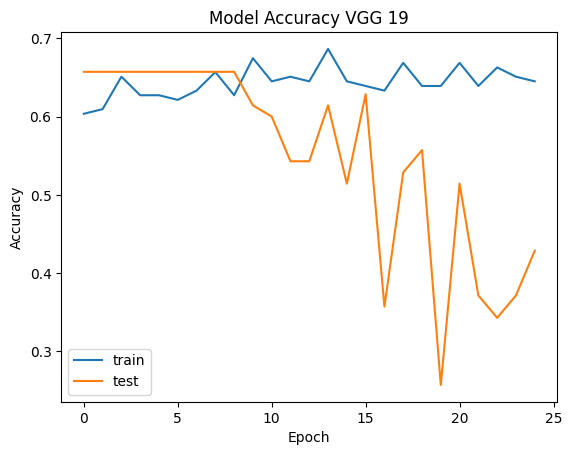

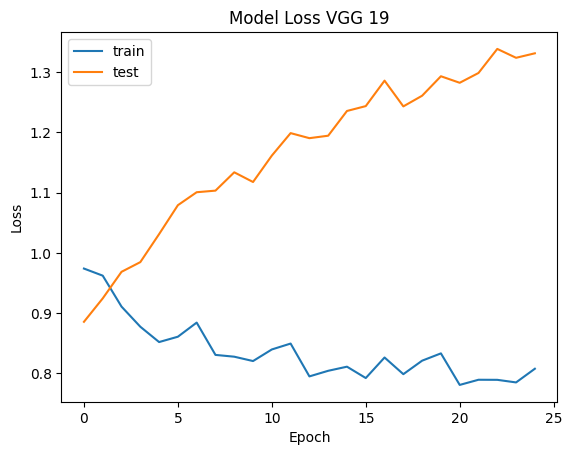

In [23]:
# list all data in history
print(history_VGG19.history.keys())
# summarize history for accuracy
plt.plot(history_VGG19.history['accuracy'])
plt.plot(history_VGG19.history['val_accuracy'])
plt.title('Model Accuracy VGG 19')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history_VGG19.history['loss'])
plt.plot(history_VGG19.history['val_loss'])
plt.title('Model Loss VGG 19')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

DenseNet169

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


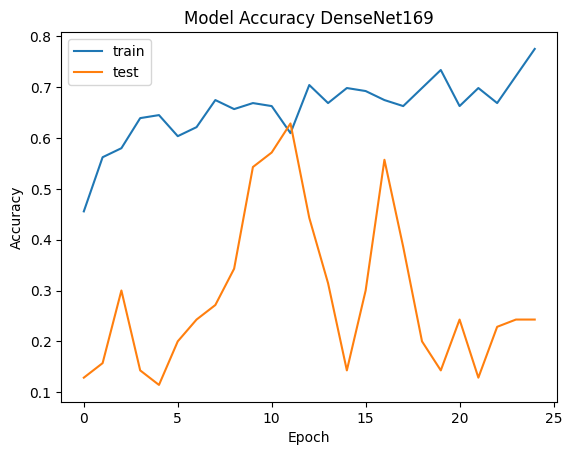

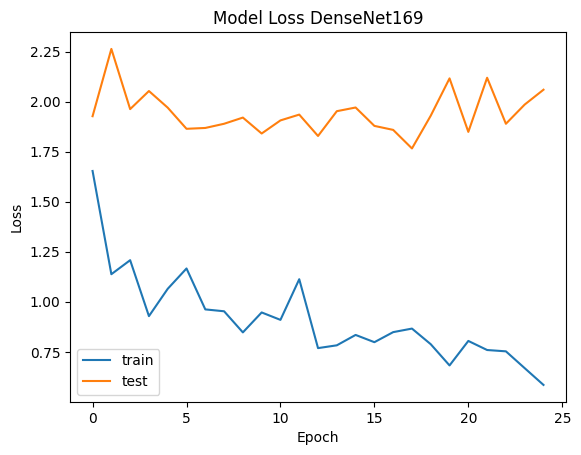

In [24]:
# list all data in history
print(history_DenseNet169.history.keys())
# summarize history for accuracy
plt.plot(history_DenseNet169.history['accuracy'])
plt.plot(history_DenseNet169.history['val_accuracy'])
plt.title('Model Accuracy DenseNet169')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history_DenseNet169.history['loss'])
plt.plot(history_DenseNet169.history['val_loss'])
plt.title('Model Loss DenseNet169')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

ConvNeXtTiny

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


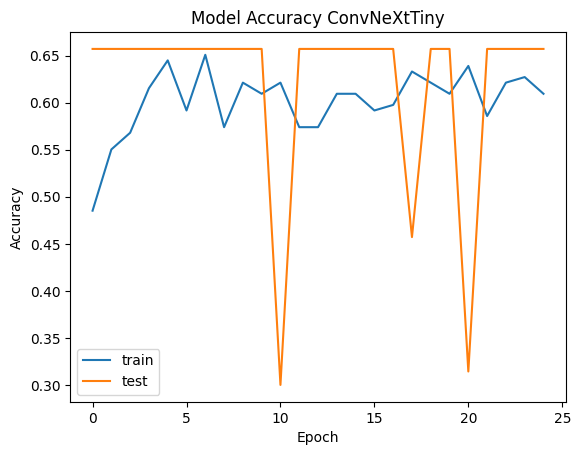

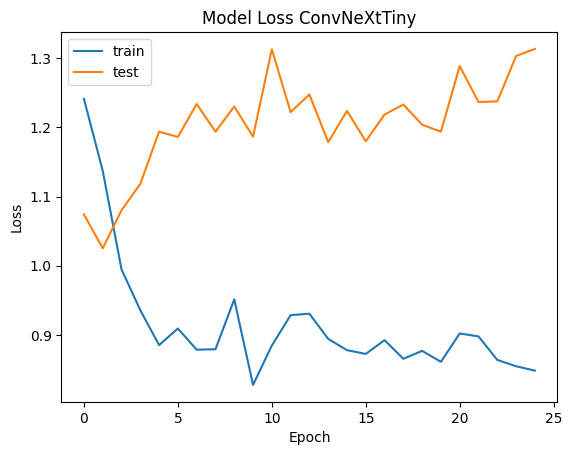

In [25]:
# list all data in history
print(history_ConvNeXtTiny.history.keys())
# summarize history for accuracy
plt.plot(history_ConvNeXtTiny.history['accuracy'])
plt.plot(history_ConvNeXtTiny.history['val_accuracy'])
plt.title('Model Accuracy ConvNeXtTiny')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history_ConvNeXtTiny.history['loss'])
plt.plot(history_ConvNeXtTiny.history['val_loss'])
plt.title('Model Loss ConvNeXtTiny')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# **Save the model and last weights**

In [26]:
timestr = time.strftime("%Y%m%d_%H%M%S")

# serialize model to JSON
model_VGG16_json = model_VGG16.to_json()
with open(timestr+"_"+modelName+"_MODEL_3"+".json", "w") as json_file:
    json_file.write(model_VGG16_json)
# serialize weights to HDF5
model_VGG16.save_weights(timestr+"_"+modelName+"_3_LAST_WEIGHTS_"+".h5")

model_VGG19_json = model_VGG19.to_json()
with open(timestr+"_"+modelName+"_MODEL_3"+".json", "w") as json_file:
    json_file.write(model_VGG19_json)
model_VGG19.save_weights(timestr+"_"+modelName+"_3_LAST_WEIGHTS_"+".h5")

model_DenseNet169_json = model_DenseNet169.to_json()
with open(timestr+"_"+modelName+"_MODEL_3"+".json", "w") as json_file:
    json_file.write(model_DenseNet169_json)
model_DenseNet169.save_weights(timestr+"_"+modelName+"_3_LAST_WEIGHTS_"+".h5")

model_ConvNeXtTiny_json = model_ConvNeXtTiny.to_json()
with open(timestr+"_"+modelName+"_MODEL_3"+".json", "w") as json_file:
    json_file.write(model_ConvNeXtTiny_json)
model_ConvNeXtTiny.save_weights(timestr+"_"+modelName+"_3_LAST_WEIGHTS_"+".h5")


# **Evaulate the model**

In [27]:
validation_generator.reset()

score_VGG16 = model_VGG16.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)
print("VGG 16:")
print("For validation data set\nLoss: ",score_VGG16[0],"\nAccuracy: ", score_VGG16[1])

score_VGG19 = model_VGG19.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)
print("VGG 19:")
print("For validation data set\nLoss: ",score_VGG19[0],"\nAccuracy: ", score_VGG19[1])

score_DenseNet169 = model_DenseNet169.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)
print("DenseNet169:")
print("For validation data set\nLoss: ",score_DenseNet169[0],"\nAccuracy: ", score_DenseNet169[1])

score_ConvNeXtTiny = model_ConvNeXtTiny.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)
print("ConvNeXtTiny:")
print("For validation data set\nLoss: ",score_ConvNeXtTiny[0]," \nAccuracy: ", score_ConvNeXtTiny[1])

C:\Users\91810\AppData\Local\Temp\ipykernel_24012\3530192685.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score_VGG16 = model_VGG16.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)


VGG 16:
For validation data set
Loss:  1.3376798629760742 
Accuracy:  0.34285715222358704


C:\Users\91810\AppData\Local\Temp\ipykernel_24012\3530192685.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score_VGG19 = model_VGG19.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)


VGG 19:
For validation data set
Loss:  1.2933074235916138 
Accuracy:  0.4285714328289032


C:\Users\91810\AppData\Local\Temp\ipykernel_24012\3530192685.py:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score_DenseNet169 = model_DenseNet169.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)


DenseNet169:
For validation data set
Loss:  1.959472417831421 
Accuracy:  0.2571428716182709


C:\Users\91810\AppData\Local\Temp\ipykernel_24012\3530192685.py:15: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score_ConvNeXtTiny = model_ConvNeXtTiny.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)


ConvNeXtTiny:
For validation data set
Loss:  1.2355892658233643  
Accuracy:  0.6571428775787354


# **Make Predictions**

In [28]:
validation_generator.reset()
testStep = (validation_generator.samples + (batchSize-1)) // batchSize
print("testStep: ", testStep)

print("VGG 16:")
predictions_VGG16 = model_VGG16.predict_generator(validation_generator, steps = testStep ,  verbose = 1)
print(len(predictions_VGG16))

print("VGG 19:")
predictions_VGG19 = model_VGG19.predict_generator(validation_generator, steps = testStep ,  verbose = 1)
print(len(predictions_VGG19))

print("DenseNet169:")
predictions_DenseNet169 = model_DenseNet169.predict_generator(validation_generator, steps = testStep ,  verbose = 1)
print(len(predictions_DenseNet169))

print("ConvNeXtTiny:")
predictions_ConvNeXtTiny = model_ConvNeXtTiny.predict_generator(validation_generator, steps = testStep ,  verbose = 1)
print(len(predictions_ConvNeXtTiny))

testStep:  12
VGG 16:


C:\Users\91810\AppData\Local\Temp\ipykernel_24012\1241048804.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_VGG16 = model_VGG16.predict_generator(validation_generator, steps = testStep ,  verbose = 1)


12/12 [==============================] - 4s 333ms/step
70
VGG 19:


C:\Users\91810\AppData\Local\Temp\ipykernel_24012\1241048804.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_VGG19 = model_VGG19.predict_generator(validation_generator, steps = testStep ,  verbose = 1)


12/12 [==============================] - 8s 677ms/step
70
DenseNet169:


C:\Users\91810\AppData\Local\Temp\ipykernel_24012\1241048804.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_DenseNet169 = model_DenseNet169.predict_generator(validation_generator, steps = testStep ,  verbose = 1)


12/12 [==============================] - 9s 425ms/step
70
ConvNeXtTiny:


C:\Users\91810\AppData\Local\Temp\ipykernel_24012\1241048804.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_ConvNeXtTiny = model_ConvNeXtTiny.predict_generator(validation_generator, steps = testStep ,  verbose = 1)


12/12 [==============================] - 26s 2s/step
70


# **Decode Labels**

In [29]:
print("VGG 16:")
predicted_class_indices_VGG16=np.argmax(predictions_VGG16,axis=1)
print(predicted_class_indices_VGG16)
len(predicted_class_indices_VGG16)

print("VGG 19:")
predicted_class_indices_VGG19=np.argmax(predictions_VGG19,axis=1)
print(predicted_class_indices_VGG19)
len(predicted_class_indices_VGG19)

print("DenseNet169:")
predicted_class_indices_DenseNet169=np.argmax(predictions_DenseNet169,axis=1)
print(predicted_class_indices_DenseNet169)
len(predicted_class_indices_DenseNet169)

print("ConvNeXtTiny:")
predicted_class_indices_ConvNeXtTiny=np.argmax(predictions_ConvNeXtTiny,axis=1)
print(predicted_class_indices_ConvNeXtTiny)
len(predicted_class_indices_ConvNeXtTiny)

VGG 16:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 2 2 1 2 2 1 2 1 2 2 2 2 1 1 2 2 1
 1 2 1 2 1 2 2 1 2 2 2 2 1 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
VGG 19:
[1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 2 1 2 2 1 1 2 1 2 1 1 2 1 1 1 1 1 1 1
 1 2 1 1 2 1 2 1 1 2 2 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
DenseNet169:
[1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 1 2 1 2 1 2 2 1 2 1 0 2 1 0 2 2 2 2 1 1 1 2
 1 2 1 2 2 2 2 1 2 2 2 2 2 0 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
ConvNeXtTiny:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


70

In [30]:
labels = (validation_generator.class_indices)
print(labels)

{'normal': 0, 'osteopenia': 1, 'osteoporosis': 2}


In [31]:
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'normal', 1: 'osteopenia', 2: 'osteoporosis'}


In [32]:
print("VGG 16:")
predictedLables_VGG16= [labels[k] for k in predicted_class_indices_VGG16]
print(predictedLables_VGG16)
print(len(predictedLables_VGG16))

print("VGG 19:")
predictedLables_VGG19= [labels[k] for k in predicted_class_indices_VGG19]
print(predictedLables_VGG19)
print(len(predictedLables_VGG19))

print("DenseNet169:")
predictedLables_DenseNet169= [labels[k] for k in predicted_class_indices_DenseNet169]
print(predictedLables_DenseNet169)
print(len(predictedLables_DenseNet169))

print("ConvNeXtTiny:")
predictedLables_ConvNeXtTiny= [labels[k] for k in predicted_class_indices_ConvNeXtTiny]
print(predictedLables_ConvNeXtTiny)
print(len(predictedLables_ConvNeXtTiny))

VGG 16:
['osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteopenia', 'osteoporosis', 'osteoporosis', 'osteopenia', 'osteoporosis', 'osteoporosis', 'osteopenia', 'osteoporosis', 'osteopenia', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteopenia', 'osteopenia', 'osteoporosis', 'osteoporosis', 'osteopenia', 'osteopenia', 'osteoporosis', 'osteopenia', 'osteoporosis', 'osteopenia', 'osteoporosis', 'osteoporosis', 'osteopenia', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteopenia', 'osteopenia', 'osteoporosis', 'osteopenia', 'osteoporosis', 'osteoporosis', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia',

In [33]:
actualLables= [labels[k] for k in validation_generator.classes]
print(actualLables)
len(actualLables)

['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis']


70

# **Accuracy**

In [34]:
print("Accuracy scores : \n")
print("VGG 16 :")
print (accuracy_score(actualLables, predictedLables_VGG16))

print("VGG 19:")
print (accuracy_score(actualLables, predictedLables_VGG19))

print("DenseNet169:")
print (accuracy_score(actualLables, predictedLables_DenseNet169))

print("ConvNeXtTiny:")
print (accuracy_score(actualLables, predictedLables_ConvNeXtTiny))

Accuracy scores : 

VGG 16 :
0.2714285714285714
VGG 19:
0.4142857142857143
DenseNet169:
0.22857142857142856
ConvNeXtTiny:
0.6571428571428571


# **Evaluation metrics based on a confusion matrix**

In [35]:
print(labels)

print("\nVGG 16 :")
matrix_VGG16 = confusion_matrix(actualLables, predictedLables_VGG16)
print(matrix_VGG16)

print("\nVGG 19:")
matrix_VGG19 = confusion_matrix(actualLables, predictedLables_VGG19)
print(matrix_VGG19)

print("\nDenseNet169:")
matrix_DenseNet169 = confusion_matrix(actualLables, predictedLables_DenseNet169)
print(matrix_DenseNet169)

print("\nConvNeXtTiny:")
matrix_ConvNeXtTiny = confusion_matrix(actualLables, predictedLables_ConvNeXtTiny)
print(matrix_ConvNeXtTiny)

{0: 'normal', 1: 'osteopenia', 2: 'osteoporosis'}

VGG 16 :
[[ 0 10  0]
 [ 0 19 27]
 [ 0 14  0]]

VGG 19:
[[ 0 10  0]
 [ 0 29 17]
 [ 0 14  0]]

DenseNet169:
[[ 0 10  0]
 [ 4 16 26]
 [ 0 14  0]]

ConvNeXtTiny:
[[ 0 10  0]
 [ 0 46  0]
 [ 0 14  0]]


# **The precision and recall metrics**

VGG 16

In [36]:
print(classification_report(actualLables, predictedLables_VGG16))
print("Recall score: ")
print(recall_score( actualLables, predictedLables_VGG16,average='weighted') )
print("Precision score: ")
print(precision_score( actualLables, predictedLables_VGG16,average='weighted') )

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        10
  osteopenia       0.44      0.41      0.43        46
osteoporosis       0.00      0.00      0.00        14

    accuracy                           0.27        70
   macro avg       0.15      0.14      0.14        70
weighted avg       0.29      0.27      0.28        70

Recall score: 
0.2714285714285714
Precision score: 
0.2903654485049834


C:\Users\91810\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91810\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91810\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

VGG 19

In [37]:
print(classification_report(actualLables, predictedLables_VGG19))
print("Recall score: ")
print(recall_score( actualLables, predictedLables_VGG19,average='weighted') )
print("Precision score: ")
print(precision_score( actualLables, predictedLables_VGG19,average='weighted') )

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        10
  osteopenia       0.55      0.63      0.59        46
osteoporosis       0.00      0.00      0.00        14

    accuracy                           0.41        70
   macro avg       0.18      0.21      0.20        70
weighted avg       0.36      0.41      0.38        70

Recall score: 
0.4142857142857143
Precision score: 
0.35956873315363885


C:\Users\91810\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91810\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91810\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

DenseNet169

In [38]:
print(classification_report(actualLables, predictedLables_DenseNet169))
print("Recall score: ")
print(recall_score( actualLables, predictedLables_DenseNet169,average='weighted') )
print("Precision score: ")
print(precision_score( actualLables, predictedLables_DenseNet169,average='weighted') )

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        10
  osteopenia       0.40      0.35      0.37        46
osteoporosis       0.00      0.00      0.00        14

    accuracy                           0.23        70
   macro avg       0.13      0.12      0.12        70
weighted avg       0.26      0.23      0.24        70

Recall score: 
0.22857142857142856
Precision score: 
0.2628571428571429


ConvNeXtTiny

In [39]:
print(classification_report(actualLables, predictedLables_ConvNeXtTiny))
print("Recall score: ")
print(recall_score( actualLables, predictedLables_ConvNeXtTiny,average='weighted') )
print("Precision score: ")
print(precision_score( actualLables, predictedLables_ConvNeXtTiny,average='weighted') )

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        10
  osteopenia       0.66      1.00      0.79        46
osteoporosis       0.00      0.00      0.00        14

    accuracy                           0.66        70
   macro avg       0.22      0.33      0.26        70
weighted avg       0.43      0.66      0.52        70

Recall score: 
0.6571428571428571
Precision score: 
0.43183673469387757


C:\Users\91810\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91810\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91810\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,


## **Plot the confusion matrix**

In [40]:
#Prepared code that is taken from SKLearn Website, Creates Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

VGG 16

Confusion matrix, without normalization
[[ 0 10  0]
 [ 0 19 27]
 [ 0 14  0]]


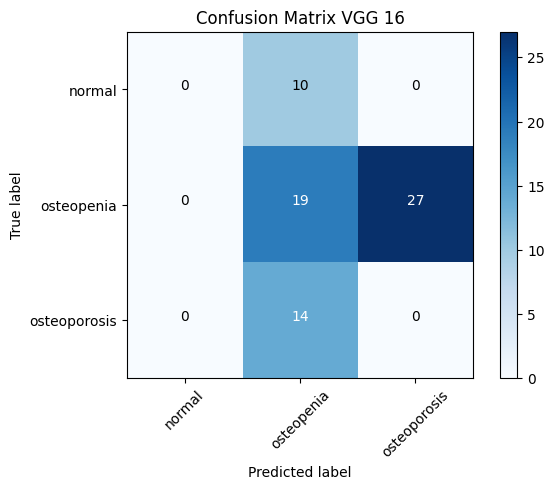

In [41]:
cm_plot_labels = selectedClasses
plot_confusion_matrix(matrix_VGG16,cm_plot_labels, normalize=False
                      , title = 'Confusion Matrix VGG 16')

VGG 19

Confusion matrix, without normalization
[[ 0 10  0]
 [ 0 29 17]
 [ 0 14  0]]


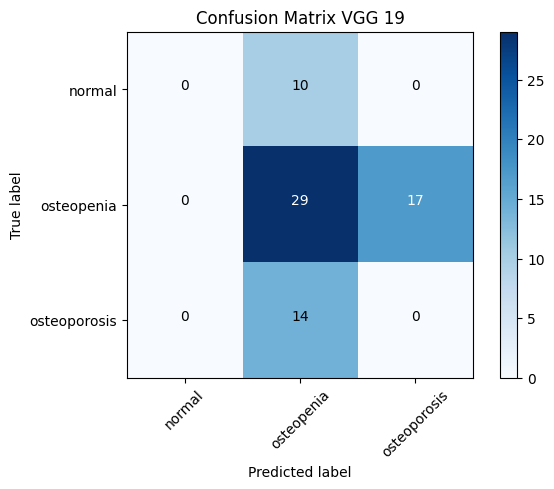

In [42]:
cm_plot_labels = selectedClasses
plot_confusion_matrix(matrix_VGG19,cm_plot_labels, normalize=False
                      , title = 'Confusion Matrix VGG 19')

DenseNet169

Confusion matrix, without normalization
[[ 0 10  0]
 [ 4 16 26]
 [ 0 14  0]]


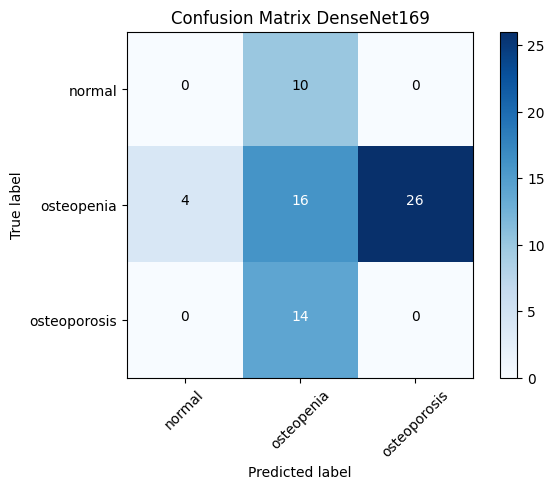

In [43]:
cm_plot_labels = selectedClasses
plot_confusion_matrix(matrix_DenseNet169,cm_plot_labels, normalize=False
                      , title = 'Confusion Matrix DenseNet169')

ConvNeXtTiny

Confusion matrix, without normalization
[[ 0 10  0]
 [ 0 46  0]
 [ 0 14  0]]


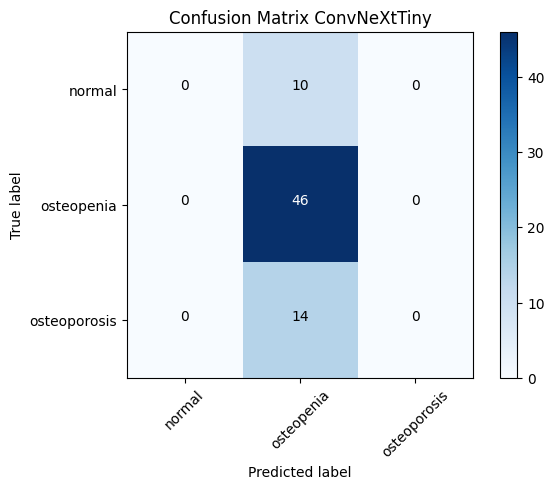

In [44]:
cm_plot_labels = selectedClasses
plot_confusion_matrix(matrix_ConvNeXtTiny,cm_plot_labels, normalize=False
                      , title = 'Confusion Matrix ConvNeXtTiny')

# **Save Predictions**

In [45]:
filenames=validation_generator.filenames
directory= validation_generator.directory

results_VGG16=pd.DataFrame({"Directory":directory,
                      "Filename":filenames,
                      "Predictions":predictedLables_VGG16,
                     "Actuals": actualLables })
results_VGG16.to_csv("results_VGG16.csv",index=False)

results_VGG19=pd.DataFrame({"Directory":directory,
                      "Filename":filenames,
                      "Predictions":predictedLables_VGG19,
                     "Actuals": actualLables })
results_VGG19.to_csv("results_VGG19.csv",index=False)

results_DenseNet169=pd.DataFrame({"Directory":directory,
                      "Filename":filenames,
                      "Predictions":predictedLables_DenseNet169,
                     "Actuals": actualLables })
results_DenseNet169.to_csv("results_DenseNet169.csv",index=False)

results_ConvNeXtTiny=pd.DataFrame({"Directory":directory,
                      "Filename":filenames,
                      "Predictions":predictedLables_ConvNeXtTiny,
                     "Actuals": actualLables })
results_ConvNeXtTiny.to_csv("results_ConvNeXtTiny.csv",index=False)

# **Show some sample predictions with corresponding true**

In [47]:
#import glob
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

res = results[260:280]

images = []
#for img_path in glob.glob('images/*.jpg'):
for img_path in "./"+res['Directory']+"/"+res['Filename']:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(80,80))
columns = 4
for i, image in enumerate(images):
    ax= plt.subplot(len(images) / columns + 1, columns, i + 1)
    ax.set_title(res['Actuals'].iloc[i]+" "+res['Predictions'].iloc[i], fontsize=40)
    plt.imshow(image)

NameError: name 'results' is not defined